# Overview

Here we lay out an method to classify respiratory disease using a convolutional neural network. Image features are combined together to make the input. Because all these features need to be extracted it takes about 40 mins to run (make yourself a coffee or something). This method achieves an accuracy of 95% and a loss of around 0.2.

In [30]:
from os import listdir
import os
from os.path import isfile, join
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
###
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,CSVLogger
from tensorflow import keras
###
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout,Input, GlobalAveragePooling2D, Reshape
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf


# Parsing the Dataset

In [31]:
class Diagnosis():
  def __init__ (self, id, diagnosis, image_path):
    self.id = id
    self.diagnosis = diagnosis 
    self.image_path = image_path   

In [32]:
def get_wav_files():
  audio_path = 'Respiratory_Sound_Database/audio_and_txt_files/'
  files = [f for f in listdir(audio_path) if isfile(join(audio_path, f))]  #Gets all files in dir
  wav_files = [f for f in files if f.endswith('.wav')]  # Gets wav files 
  wav_files = sorted(wav_files)
  return wav_files, audio_path

In [33]:
def diagnosis_data():
  diagnosis = pd.read_csv('Respiratory_Sound_Database/patient_diagnosis.csv')
  
  wav_files, audio_path = get_wav_files()
  diag_dict = { 101 : "URTI"}  
  diagnosis_list = []
  
  for index , row in diagnosis.iterrows():
    diag_dict[row[0]] = row[1]     

  c = 0
  for f in wav_files:
    diagnosis_list.append(Diagnosis(c, diag_dict[int(f[:3])], audio_path+f))  
    c+=1  

  return diagnosis_list

# Feature Extraction

In [34]:
def audio_features(filename): 
  sound, sample_rate = librosa.load(filename)
  stft = np.abs(librosa.stft(sound))  
 
  mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40),axis=1)
  chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate),axis=1)
  mel = np.mean(librosa.feature.melspectrogram(y=sound, sr=sample_rate), axis=1)
  contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate),axis=1)
  tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate),axis=1)
    
  concat = np.concatenate((mfccs,chroma,mel,contrast,tonnetz))
  return concat

def data_points():
  labels = []
  images = []

  to_hot_one = {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}

  count = 0
  for f in diagnosis_data():
    print(count)
    labels.append(to_hot_one[f.diagnosis]) 
    images.append(audio_features(f.image_path))
    count+=1

  return np.array(labels), np.array(images)

# Preprocessing

In [35]:
def preprocessing(labels, images):    

  # Remove Asthma and LRTI
  images = np.delete(images, np.where((labels == 7) | (labels == 6))[0], axis=0) 
  labels = np.delete(labels, np.where((labels == 7) | (labels == 6))[0], axis=0)      

  # Split data
  X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=10)

  # Hot one encode the labels
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)  

  # Format new data
  y_train = np.reshape(y_train, (y_train.shape[0], 6))
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  y_test = np.reshape(y_test, (y_test.shape[0], 6))
  X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1],  1))

  return X_train, X_test, y_train, y_test

## Callbacks

In [36]:
os.makedirs('model/cdd_resnet_aug',exist_ok=True)
save_dir='model/cdd_resnet_aug/cdd_resnet_aug.keras'
checkpoint = keras.callbacks.ModelCheckpoint(save_dir,
                                            monitor='accuracy', 
                                            save_best_only=True,
                                            verbose=1,
                                            mode='auto',
                                            save_freq=163)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=20,
                                            mode='auto',
                                            verbose=1,
                                            restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.1,
                                            min_delta=.0001)
csvlogger =  tf.keras.callbacks.CSVLogger('model/cdd_resnet_aug/log.csv',
                                        separator=',',
                                        append=True)
callbacks = [checkpoint, early_stopping, reduce_lr,csvlogger]

In [37]:
labels, images = data_points()
X_train, X_test, y_train, y_test = preprocessing(labels, images)

C:\Users\shark\AppData\Local\Temp\ipykernel_10880\897719341.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diag_dict[row[0]] = row[1]


0


c:\ProgramData\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [38]:
#start = timer()

#labels, images = data_points()
#X_train, X_test, y_train, y_test = preprocessing(labels, images)


# MobileNetV2

In [39]:
X_train.shape

(733, 193, 1)

In [40]:
"""# Reshape input to fit a CNN model (pseudo 2D)
input_shape = (193, 193, 3)  # Fake 2D shape (adjust as needed)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze pretrained layers
for layer in base_model.layers:
    layer.trainable = False

# Custom layers
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(6, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, verbose=1)
"""

# Reshape the input data to match MobileNetV2's expected input shape
# MobileNetV2 expects input in the shape (height, width, channels)
X_train = X_train.reshape(X_train.shape[0], 193, 1, 1)
X_test = X_test.reshape(X_test.shape[0], 193, 1, 1)

# Define the MobileNetV2 base model
input_tensor = Input(shape=(193, 1, 1))  # Adjusted for single-channel input
base_model = MobileNetV2(weights=None, include_top=False, input_tensor=input_tensor)

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output = Dense(6, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=200, verbose=1)

Epoch 1/150


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_470']
Received: inputs=Tensor(shape=(None, 193, 1, 1))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 917ms/step - accuracy: 0.5225 - loss: 1.2046 - val_accuracy: 0.8967 - val_loss: 1.7384
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 414ms/step - accuracy: 0.8497 - loss: 0.5494 - val_accuracy: 0.8967 - val_loss: 1.7254
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 415ms/step - accuracy: 0.8649 - loss: 0.4036 - val_accuracy: 0.8967 - val_loss: 1.7261
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - accuracy: 0.8653 - loss: 0.3993 - val_accuracy: 0.8967 - val_loss: 1.7338
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 413ms/step - accuracy: 0.8686 - loss: 0.3468 - val_accuracy: 0.8967 - val_loss: 1.7394
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - accuracy: 0.8716 - loss: 0.3165 - val_accuracy: 0.8967 - val_loss: 1.7463
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 417ms/step - accuracy: 0.8818 - loss: 0.2885 - val_accuracy: 0.8967 - val_loss: 1.7510
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 419ms/step - accuracy: 0.8853 - loss: 0.2843 - val_accuracy: 0.8967 - val_loss: 1.

# Evaluation

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_470']
Received: inputs=Tensor(shape=(None, 193, None, 1))
  warnings.warn(msg)


Accuracy: 90%
Loss: 0.8287



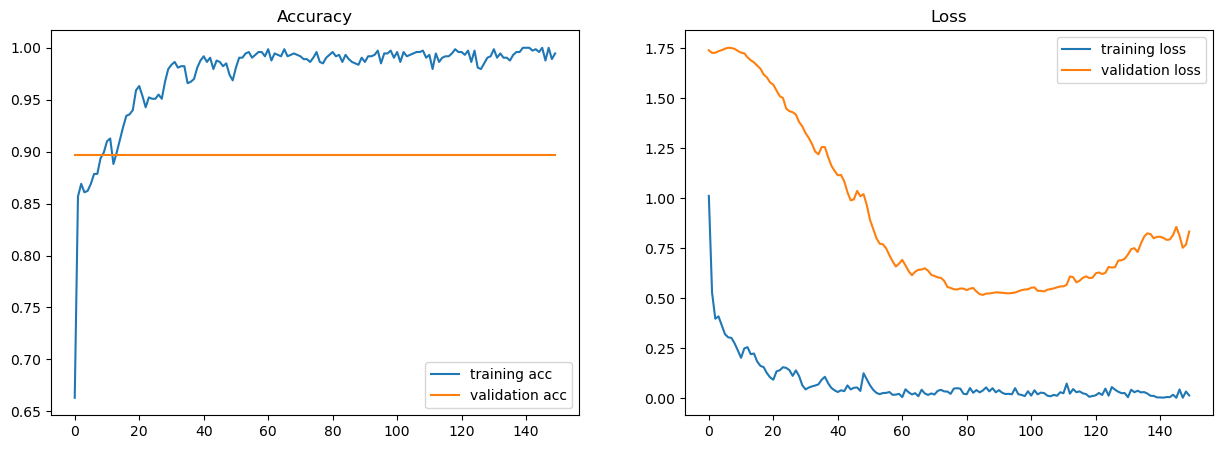

In [56]:
score = model.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

# Custom 1D-CNN + LSTM

In [42]:
# from keras.models import Sequential
# from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, LSTM, Reshape

# model1 = Sequential()

# # Add Conv1D layers for feature extraction
# model1.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(193, 1)))
# model1.add(Conv1D(128, kernel_size=5, activation='relu'))
# model1.add(MaxPooling1D(2))

# # Add additional Conv1D layer
# model1.add(Conv1D(256, kernel_size=5, activation='relu'))

# # Add Dropout for regularization
# model1.add(Dropout(0.3))

# # Reshape the output to 3D for LSTM
# model1.add(Reshape((-1, 256)))

# # Add LSTM layer for sequential modeling
# model1.add(LSTM(128, activation='relu', return_sequences=False))

# # Fully connected Dense layers
# model1.add(Dense(512, activation='relu'))   
# model1.add(Dense(6, activation='softmax'))

# # Compile the model
# model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train the model
# history1 = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, verbose=1)


## Evaluation for Custom 1D-CNN + LSTM

In [43]:
# score1 = model1.evaluate(X_test, y_test, batch_size=60, verbose=0)
# print('Accuracy: {0:.0%}'.format(score1[1]/1))
# print("Loss: %.4f\n" % score1[0])

# # Plot accuracy and loss graphs
# plt.figure(figsize = (15,5))
# plt.subplot(1,2,1)
# plt.title('Accuracy')
# plt.plot(history1.history['accuracy'], label = 'training acc')
# plt.plot(history1.history['val_accuracy'], label = 'validation acc')
# plt.legend()

# plt.subplot(1,2,2)
# plt.title('Loss')
# plt.plot(history1.history['loss'], label = 'training loss')
# plt.plot(history1.history['val_loss'], label = 'validation loss')
# plt.legend()

# Spectrogram + ResNet/EfficientNet

In [44]:
# from tensorflow.keras.applications import ResNet50, EfficientNetB0
# from tensorflow.keras.layers import Conv2D, MaxPooling2D


# # Choose the base model (ResNet or EfficientNet)
# base_model1 = EfficientNetB0(weights=None, include_top=False, input_tensor=input_tensor)

# # Freeze pretrained layers
# for layer in base_model1.layers:
#     layer.trainable = False

# # Custom layers
# x1 = Flatten()(base_model1.output)
# x1 = Dense(512, activation='relu')(x1)
# x1 = Dense(6, activation='softmax')(x1)

# # Compile the model
# model2 = Model(inputs=base_model.input, outputs=x1)
# model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train the model
# history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, verbose=1)


# Evaluation for Spectrogram + ResNet/EfficientNet

In [45]:
# score2 = model2.evaluate(X_test, y_test, batch_size=60, verbose=0)
# print('Accuracy: {0:.0%}'.format(score2[1]/1))
# print("Loss: %.4f\n" % score2[0])

# # Plot accuracy and loss graphs
# plt.figure(figsize = (15,5))
# plt.subplot(1,2,1)
# plt.title('Accuracy')
# plt.plot(history2.history['accuracy'], label = 'training acc')
# plt.plot(history2.history['val_accuracy'], label = 'validation acc')
# plt.legend()

# plt.subplot(1,2,2)
# plt.title('Loss')
# plt.plot(history2.history['loss'], label = 'training loss')
# plt.plot(history2.history['val_loss'], label = 'validation loss')
# plt.legend()

# Attention-Based CNN Models CBAM

In [46]:
# import tensorflow as tf
# from keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Multiply
# from keras.models import Model

# # CBAM Module (Convolutional Block Attention Module)
# class CBAM(tf.keras.layers.Layer):
#     def __init__(self, channel_attention=True, spatial_attention=True, **kwargs):
#         super(CBAM, self).__init__(**kwargs)
#         self.channel_attention = channel_attention
#         self.spatial_attention = spatial_attention

#     def build(self, input_shape):
#         pass

#     def call(self, inputs):
#         # Channel Attention
#         if self.channel_attention:
#             channel_avg = tf.reduce_mean(inputs, axis=1, keepdims=True)
#             channel_max = tf.reduce_max(inputs, axis=1, keepdims=True)
#             channel_attention = tf.sigmoid(channel_avg + channel_max)
#             inputs = Multiply()([inputs, channel_attention])

#         # Spatial Attention
#         if self.spatial_attention:
#             spatial_avg = tf.reduce_mean(inputs, axis=-1, keepdims=True)
#             spatial_max = tf.reduce_max(inputs, axis=-1, keepdims=True)
#             spatial_attention = tf.sigmoid(spatial_avg + spatial_max)
#             inputs = Multiply()([inputs, spatial_attention])

#         return inputs

# # Define the attention-based CNN model using CBAM
# input_shape = (193, 1)

# input_layer = Input(shape=input_shape)
# x2 = Conv1D(64, kernel_size=5, activation='relu')(input_layer)
# x2 = CBAM()(x2)  # Applying CBAM
# x2 = Conv1D(128, kernel_size=5, activation='relu')(x2)
# x2 = MaxPooling1D(2)(x2)
# x2 = CBAM()(x2)  # Applying CBAM
# x2 = Conv1D(256, kernel_size=5, activation='relu')(x2)
# x2 = Dropout(0.3)(x2)
# x2 = Flatten()(x2)

# x2 = Dense(512, activation='relu')(x2)
# x2 = Dense(6, activation='softmax')(x2)

# model3 = Model(inputs=input_layer, outputs=x2)

# # Compile the model
# model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Fit the model
# history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, verbose=1)


# Evaluation Attention-Based CNN Models CBAM

In [47]:
# score3 = model3.evaluate(X_test, y_test, batch_size=60, verbose=0)
# print('Accuracy: {0:.0%}'.format(score3[1]/1))
# print("Loss: %.4f\n" % score3[0])

# # Plot accuracy and loss graphs
# plt.figure(figsize = (15,5))
# plt.subplot(1,2,1)
# plt.title('Accuracy')
# plt.plot(history3.history['accuracy'], label = 'training acc')
# plt.plot(history3.history['val_accuracy'], label = 'validation acc')
# plt.legend()

# plt.subplot(1,2,2)
# plt.title('Loss')
# plt.plot(history3.history['loss'], label = 'training loss')
# plt.plot(history3.history['val_loss'], label = 'validation loss')
# plt.legend()

# OpenL3


In [48]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.image import resize

# Fix input dimensions
if len(X_train.shape) == 3:
    X_train = np.repeat(X_train, 3, axis=-1)  # Convert to (samples, 193, 193, 3)
if len(X_test.shape) == 3:
    X_test = np.repeat(X_test, 3, axis=-1)

X_train = resize(X_train, [193, 193]).numpy()
X_test = resize(X_test, [193, 193]).numpy()

# Load a pretrained EfficientNetB0 model
base_model4 = EfficientNetB0(include_top=False, input_shape=(193, 193, 3), weights="imagenet")
base_model4.trainable = False  # Freeze the base model layers

# Add custom classification layers
model4 = Sequential([
    base_model4,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  # Adjust the output units to match your classes
])

# Compile the model
model4.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history4 = model4.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=200,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.4503 - loss: 1.4467 - val_accuracy: 0.8967 - val_loss: 0.6263 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8464 - loss: 0.8763 - val_accuracy: 0.8967 - val_loss: 0.4958 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8595 - loss: 0.6179 - val_accuracy: 0.8967 - val_loss: 0.5221 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8557 - loss: 0.6225 - val_accuracy: 0.8967 - val_loss: 0.4439 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8449 - loss: 0.6237 - val_accuracy: 0.8967 - val_loss: 0.4338 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8567 - loss: 0.5904 - val_accuracy: 0.8967 - val_loss: 0.4353 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8585 - loss: 0.5750 - val_accuracy: 0.8967 

# Evaluation of OpenL3


Accuracy: 90%
Loss: 0.6263



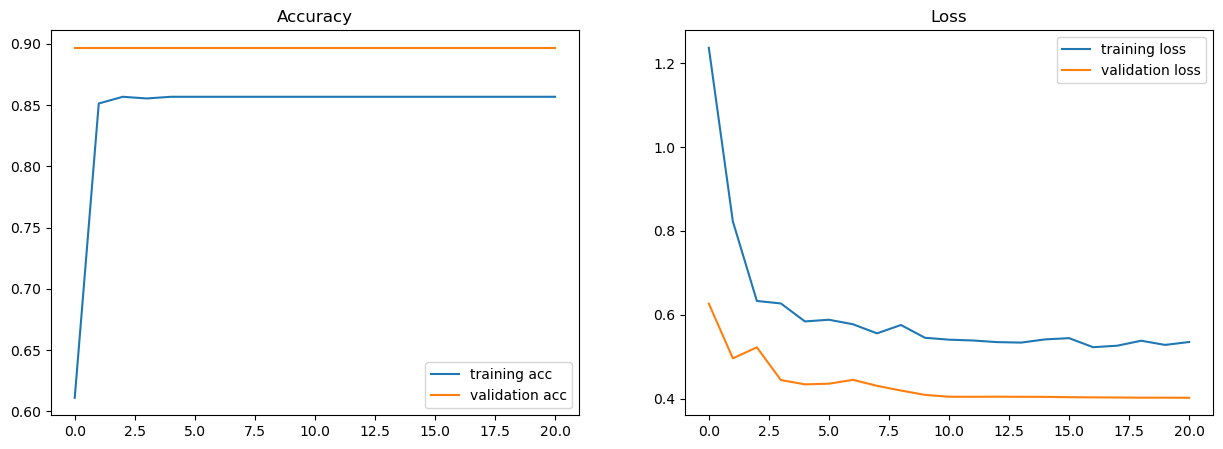

In [57]:
score4 = model4.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score4[1]/1))
print("Loss: %.4f\n" % score4[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history4.history['accuracy'], label = 'training acc')
plt.plot(history4.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history4.history['loss'], label = 'training loss')
plt.plot(history4.history['val_loss'], label = 'validation loss')
plt.legend()

# PANNs (Pre-trained Audio Neural Networks)

In [50]:
# Reshape the data to have 3 channels
#X_train = np.repeat(X_train, 3, axis=-1)  # Replicate the 1-channel input to 3 channels
#X_test = np.repeat(X_test, 3, axis=-1)    # Same for test data

# Define the model
#input_tensor = Input(shape=(193, 193, 3))  # 3 channels (RGB)
#base_model = ResNet50(weights='/kaggle/input/resnet50-notop/resnet50_notop.h5', include_top=False, input_tensor=input_tensor)

# Add custom layers
#x5 = base_model5.output
#x5 = GlobalAveragePooling2D()(x)
#x5 = Dense(512, activation='relu')(x)
#output = Dense(6, activation='softmax')(x)

# Define the complete model
#model5 = Model(inputs=base_model5.input, outputs=output)

# Compile the model
#model5.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
#history5 = model5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=200, verbose=1)


# Evaluation of PANNs (Pre-trained Audio Neural Networks)

In [51]:
# score5 = model5.evaluate(X_test, y_test, batch_size=60, verbose=0)
# print('Accuracy: {0:.0%}'.format(score5[1]/1))
# print("Loss: %.4f\n" % score5[0])

# # Plot accuracy and loss graphs
# plt.figure(figsize = (15,5))
# plt.subplot(1,2,1)
# plt.title('Accuracy')
# plt.plot(history5.history['accuracy'], label = 'training acc')
# plt.plot(history5.history['val_accuracy'], label = 'validation acc')
# plt.legend()

# plt.subplot(1,2,2)
# plt.title('Loss')
# plt.plot(history5.history['loss'], label = 'training loss')
# plt.plot(history5.history['val_loss'], label = 'validation loss')
# plt.legend()

## VGG16

In [52]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Adjust the input shape to have 3 channels
X_train_vgg1 = np.repeat(X_train, 3, axis=-1)
X_test_vgg1 = np.repeat(X_test, 3, axis=-1)

# Reshape the input data to match the expected input shape of VGG16
X_train_vgg1 = X_train_vgg1.reshape(X_train_vgg1.shape[0], 193, 193, 3)
X_test_vgg1 = X_test_vgg1.reshape(X_test_vgg1.shape[0], 193, 193, 3)

input_shape = (193, 193, 3) 

# Load VGG16 model with ImageNet weights, excluding the top classification layers
base_model7 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze pretrained layers
for layer in base_model7.layers:
    layer.trainable = False

# Custom layers
x7 = Flatten()(base_model7.output)
x7 = Dense(512, activation='relu')(x7)
x7 = Dense(6, activation='softmax')(x7)

# Compile the model
model7 = Model(inputs=base_model7.input, outputs=x7)
model7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history7 = model7.fit(X_train_vgg1, y_train, validation_data=(X_test_vgg1, y_test),callbacks=callbacks, epochs=100, batch_size=200, verbose=1)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 11s/step - accuracy: 0.4740 - loss: 28.5526 - val_accuracy: 0.8478 - val_loss: 18.1607 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 10s/step - accuracy: 0.8211 - loss: 34.1014 - val_accuracy: 0.7120 - val_loss: 22.0611 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 10s/step - accuracy: 0.7321 - loss: 36.2598 - val_accuracy: 0.8696 - val_loss: 16.3395 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 10s/step - accuracy: 0.7534 - loss: 30.0828 - val_accuracy: 0.8587 - val_loss: 12.4758 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 10s/step - accuracy: 0.8322 - loss: 15.9536 - val_accuracy: 0.7772 - val_loss: 11.0024 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 10s/step - accuracy: 0.7573 - loss: 13.1923 - val_accuracy: 0.8750 - val_loss: 8.9954 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 10s/step - accuracy: 0.8245 - loss: 8.1698 - val

### Evaluation of VGG16

Accuracy: 90%
Loss: 0.9969



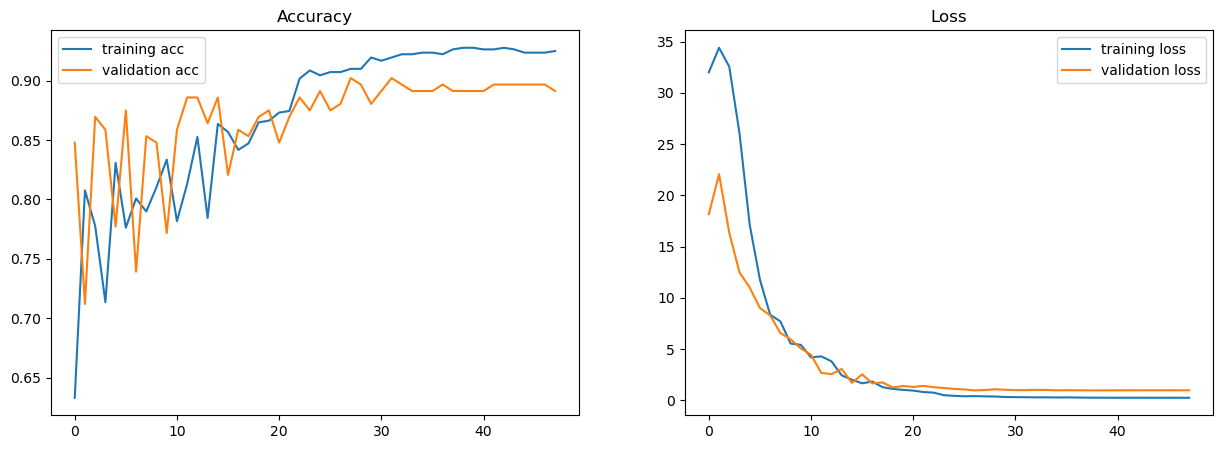

In [54]:
score7 = model7.evaluate(X_test_vgg1, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score7[1]/1))
print("Loss: %.4f\n" % score7[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history7.history['accuracy'], label = 'training acc')
plt.plot(history7.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history7.history['loss'], label = 'training loss')
plt.plot(history7.history['val_loss'], label = 'validation loss')
plt.legend()

In [42]:
print('Accuracy: {0:.0%}'.format(score7[1]/1))
print("Loss: %.4f\n" % score7[0])

Accuracy: 86%
Loss: 0.6131



## VGG19

In [58]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Adjust the input shape to have 3 channels
X_train_vgg1 = np.repeat(X_train, 3, axis=-1)
X_test_vgg1 = np.repeat(X_test, 3, axis=-1)

input_shape = (193, 193, 3)  # Adjust this to your required input shape, VGG16 uses 224x224 typically

# Load VGG16 model with ImageNet weights, excluding the top classification layers
base_model8 = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze pretrained layers
for layer in base_model8.layers:
    layer.trainable = False

# Custom layers
x8 = Flatten()(base_model8.output)
x8 = Dense(512, activation='relu')(x8)
x8 = Dense(6, activation='softmax')(x8)

# Compile the model
model8 = Model(inputs=base_model8.input, outputs=x8)
model8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history8 = model8.fit(X_train_vgg1, y_train, validation_data=(X_test_vgg1, y_test),callbacks=callbacks, epochs=100, batch_size=200, verbose=1)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 56s 14s/step - accuracy: 0.4897 - loss: 25.9079 - val_accuracy: 0.8533 - val_loss: 24.6426 - learning_rate: 0.0010
Epoch 2/100


KeyboardInterrupt: 

### Evaluation of VGG19

Accuracy: 91%
Loss: 0.5298



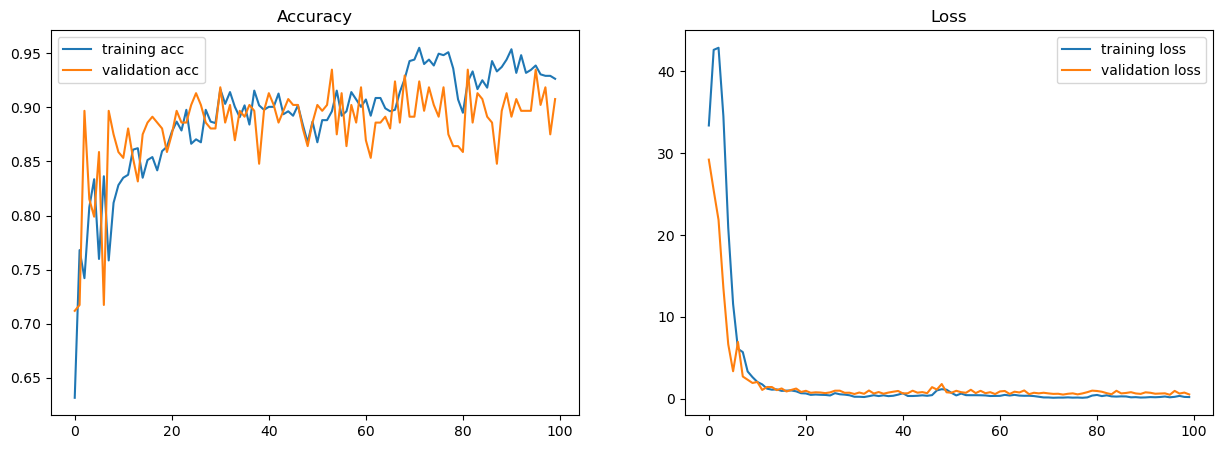

In [44]:
score8 = model8.evaluate(X_test_vgg1, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score8[1]/1))
print("Loss: %.4f\n" % score8[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history8.history['accuracy'], label = 'training acc')
plt.plot(history8.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history8.history['loss'], label = 'training loss')
plt.plot(history8.history['val_loss'], label = 'validation loss')
plt.legend()

## ResNet50

In [60]:
from tensorflow.keras.applications import ResNet50

# Adjust the input shape to have 3 channels
X_train_vgg1 = np.repeat(X_train, 3, axis=-1)
X_test_vgg1 = np.repeat(X_test, 3, axis=-1)

input_shape = (193, 193, 3)  

# Load ResNet50 model with ImageNet weights, excluding the top classification layers
base_model9 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze pretrained layers
for layer in base_model9.layers:
    layer.trainable = False

# Custom layers
x9 = Flatten()(base_model9.output)
x9 = Dense(512, activation='relu')(x9)
x9 = Dense(6, activation='softmax')(x9)

# Compile the model
model9 = Model(inputs=base_model9.input, outputs=x9)
model9.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history9 = model9.fit(X_train_vgg1, y_train, validation_data=(X_test_vgg1, y_test), callbacks=callbacks,epochs=100, batch_size=200, verbose=1)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6447 - loss: 22.9185WARNING:tensorflow:5 out of the last 18 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x0000020B8241E200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step - accuracy: 0.6656 - loss: 24.7751 - val_accuracy: 0.8967 - val_loss: 11.9719 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step - accuracy: 0.73

## Evaluation of ResNet50

Accuracy: 95%
Loss: 0.1703



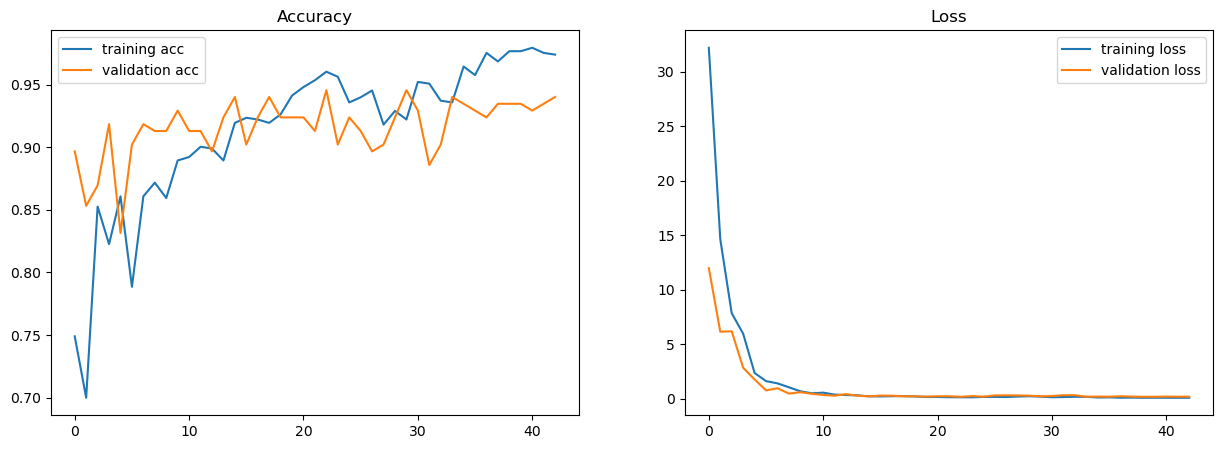

In [61]:
score9 = model9.evaluate(X_test_vgg1, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score9[1]/1))
print("Loss: %.4f\n" % score9[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history9.history['accuracy'], label = 'training acc')
plt.plot(history9.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history9.history['loss'], label = 'training loss')
plt.plot(history9.history['val_loss'], label = 'validation loss')
plt.legend()

## ResNet101

In [62]:
from tensorflow.keras.applications import ResNet101, ResNet101V2

# Adjust the input shape to have 3 channels
X_train_vgg1 = np.repeat(X_train, 3, axis=-1)
X_test_vgg1 = np.repeat(X_test, 3, axis=-1)

input_shape = (193, 193, 3)  

# Load ResNet101 and ResNet101V2 models with ImageNet weights, excluding the top classification layers
base_model10 = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
base_model11 = ResNet101V2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze pretrained layers
for layer in base_model10.layers:
    layer.trainable = False

for layer in base_model11.layers:
    layer.trainable = False

# Custom layers for ResNet101
x10 = Flatten()(base_model10.output)
x10 = Dense(512, activation='relu')(x10)
output10 = Dense(6, activation='softmax')(x10)

# Custom layers for ResNet101V2
x11 = Flatten()(base_model11.output)
x11 = Dense(512, activation='relu')(x11)
output11 = Dense(6, activation='softmax')(x11)

# Compile the models
model10 = Model(inputs=base_model10.input, outputs=output10)
model10.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model11 = Model(inputs=base_model11.input, outputs=output11)
model11.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the models
history10 = model10.fit(X_train_vgg1, y_train, validation_data=(X_test_vgg1, y_test), callbacks=callbacks, epochs=100, batch_size=200, verbose=1)
history11 = model11.fit(X_train_vgg1, y_train, validation_data=(X_test_vgg1, y_test), callbacks=callbacks, epochs=100, batch_size=200, verbose=1)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 65s 15s/step - accuracy: 0.5038 - loss: 26.0277 - val_accuracy: 0.8967 - val_loss: 26.2758 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - accuracy: 0.8424 - loss: 30.1423 - val_accuracy: 0.8315 - val_loss: 9.7929 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 11s/step - accuracy: 0.8210 - loss: 11.4212 - val_accuracy: 0.7989 - val_loss: 9.8569 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 11s/step - accuracy: 0.7692 - loss: 8.8226 - val_accuracy: 0.9130 - val_loss: 4.2613 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 11s/step - accuracy: 0.8526 - loss: 4.8136 - val_accuracy: 0.8641 - val_loss: 2.4379 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 11s/step - accuracy: 0.8453 - loss: 3.3189 - val_accuracy: 0.8750 - val_loss: 2.1008 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 12s/step - accuracy: 0.8492 - loss: 2.5123 - val_accura

## Evaluation of ResNet101

Accuracy: 94%
Loss: 0.2952



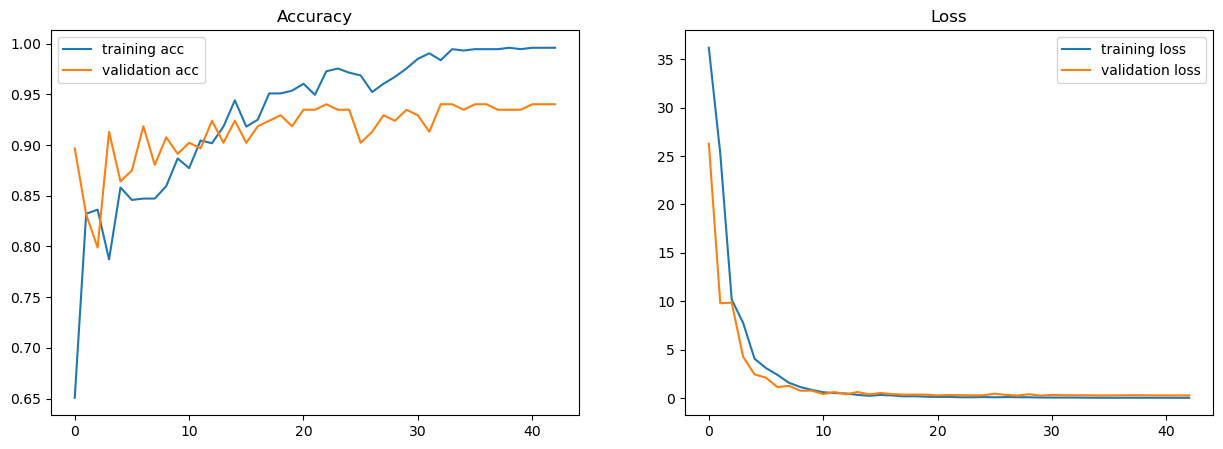

In [63]:
score10 = model10.evaluate(X_test_vgg1, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score10[1]/1))
print("Loss: %.4f\n" % score10[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history10.history['accuracy'], label = 'training acc')
plt.plot(history10.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history10.history['loss'], label = 'training loss')
plt.plot(history10.history['val_loss'], label = 'validation loss')
plt.legend()

## Evaluation of ResNet101V2

Accuracy: 94%
Loss: 1083.5134



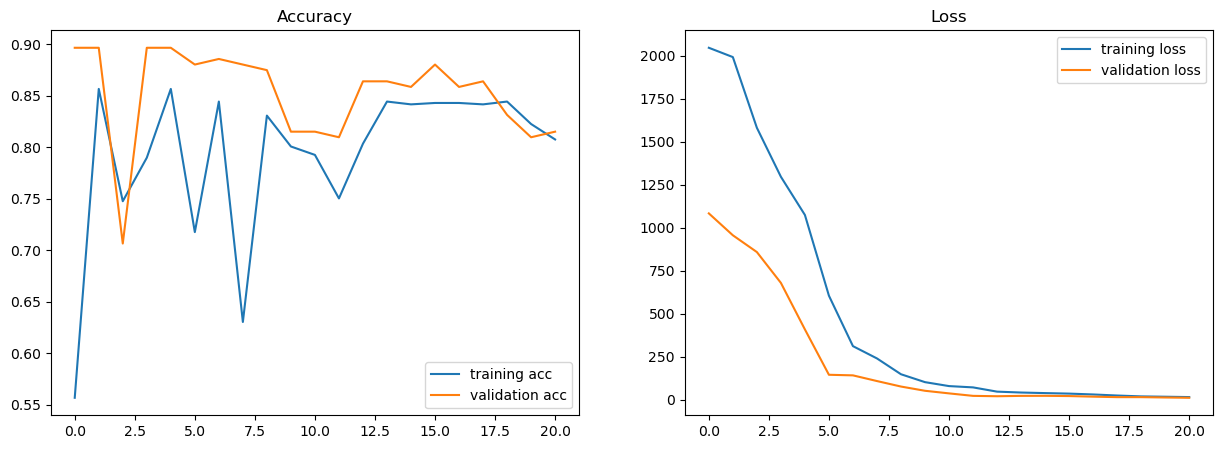

In [64]:
score11 = model11.evaluate(X_test_vgg1, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score10[1]/1))
print("Loss: %.4f\n" % score11[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history11.history['accuracy'], label = 'training acc')
plt.plot(history11.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history11.history['loss'], label = 'training loss')
plt.plot(history11.history['val_loss'], label = 'validation loss')
plt.legend()

## EfficientNet

In [ ]:
from tensorflow.keras.applications import EfficientNetV2L

# Adjust the input shape to have 3 channels
X_train_vgg1 = np.repeat(X_train, 3, axis=-1)
X_test_vgg1 = np.repeat(X_test, 3, axis=-1)

input_shape = (193, 193, 3)  

# Load EfficientNetV2L model with ImageNet weights, excluding the top classification layers
base_model12 = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze pretrained layers
for layer in base_model12.layers:
    layer.trainable = False

# Custom layers
x12 = Flatten()(base_model12.output)
x12 = Dense(512, activation='relu')(x12)
output12 = Dense(6, activation='softmax')(x12)

# Compile the model
model12 = Model(inputs=base_model12.input, outputs=output12)
model12.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history12 = model12.fit(X_train_vgg1, y_train, validation_data=(X_test_vgg1, y_test), callbacks=callbacks, epochs=100, batch_size=200, verbose=1)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 137s 26s/step - accuracy: 0.4897 - loss: 18.4782 - val_accuracy: 0.8967 - val_loss: 20.9415 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 85s 22s/step - accuracy: 0.7995 - loss: 22.6037 - val_accuracy: 0.8967 - val_loss: 9.8646 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 85s 22s/step - accuracy: 0.7627 - loss: 10.4987 - val_accuracy: 0.8641 - val_loss: 6.2918 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 87s 22s/step - accuracy: 0.8065 - loss: 7.1841 - val_accuracy: 0.7609 - val_loss: 4.9754 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 85s 22s/step - accuracy: 0.7527 - loss: 4.5441 - val_accuracy: 0.7554 - val_loss: 2.4374 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 85s 22s/step - accuracy: 0.7789 - loss: 2.3967 - val_accuracy: 0.8315 - val_loss: 1.7279 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 85s 22s/step - accuracy: 0.7697 - loss: 3.1815 - val_accur

## Evaluation of EfficientNetV2L

In [62]:
score12 = model12.evaluate(X_test_vgg1, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score12[1]/1))
print("Loss: %.4f\n" % score12[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history12.history['accuracy'], label = 'training acc')
plt.plot(history12.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history12.history['loss'], label = 'training loss')
plt.plot(history12.history['val_loss'], label = 'validation loss')
plt.legend()

NameError: name 'model12' is not defined

## DenseNet

In [63]:
from tensorflow.keras.applications import DenseNet169

# Adjust the input shape to have 3 channels
X_train_vgg1 = np.repeat(X_train, 3, axis=-1)
X_test_vgg1 = np.repeat(X_test, 3, axis=-1)

input_shape = (193, 193, 3)  

# Load DenseNet169 model with ImageNet weights, excluding the top classification layers
base_model13 = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze pretrained layers
for layer in base_model13.layers:
    layer.trainable = False

# Custom layers
x13 = Flatten()(base_model13.output)
x13 = Dense(512, activation='relu')(x13)
output13 = Dense(6, activation='softmax')(x13)

# Compile the model
model13 = Model(inputs=base_model13.input, outputs=output13)
model13.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history13 = model13.fit(X_train_vgg1, y_train, validation_data=(X_test_vgg1, y_test), callbacks=callbacks, epochs=100, batch_size=200, verbose=1)

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 29s 1us/step
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 10s/step - accuracy: 0.5012 - loss: 136.5959 - val_accuracy: 0.6848 - val_loss: 83.6414 - learning_rate: 0.0010
Epoch 2/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step - accuracy: 0.6000 - loss: 191.8950

KeyboardInterrupt: 

## Evaluation of DenseNet169

In [ ]:
score13 = model13.evaluate(X_test_vgg1, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score13[1]/1))
print("Loss: %.4f\n" % score13[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history13.history['accuracy'], label = 'training acc')
plt.plot(history13.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history13.history['loss'], label = 'training loss')
plt.plot(history13.history['val_loss'], label = 'validation loss')
plt.legend()

# WaveNet

In [76]:
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Activation, Add

# Ensure input shape is (batch_size, time_steps, channels)
if X_train.ndim == 3 and X_train.shape[-1] != 1:  # Shape: (batch_size, time_steps, channels)
    X_train = np.mean(X_train, axis=-1, keepdims=True)  # Convert to (batch_size, time_steps, 1)
    X_test = np.mean(X_test, axis=-1, keepdims=True)

input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, channels)

# WaveNet-style causal convolutional block
def residual_block(x, dilation_rate):
    res = x
    x = Conv1D(filters=64, kernel_size=2, padding="causal", dilation_rate=dilation_rate, activation="relu")(x)
    x = Conv1D(filters=64, kernel_size=2, padding="causal", dilation_rate=dilation_rate)(x)
    x = Add()([x, res])  # Residual connection
    x = Activation("relu")(x)
    return x

# Input layer
inputs = Input(shape=input_shape)

# First convolution (non-causal)
x = Conv1D(filters=64, kernel_size=2, padding="same", activation="relu")(inputs)

# Stack of residual blocks with increasing dilation rates
dilations = [1, 2, 4, 8, 16, 32]
for dilation in dilations:
    x = residual_block(x, dilation)

# Flatten and output layer
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(6, activation='softmax')(x)  # Assuming 6 classes

# Compile the model
model_wavenet = Model(inputs, outputs)
model_wavenet.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history_wavenet = model_wavenet.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, verbose=1)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 471ms/step - accuracy: 0.5292 - loss: 183.0957 - val_accuracy: 0.7880 - val_loss: 64.4229
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step - accuracy: 0.7545 - loss: 138.6833 - val_accuracy: 0.8967 - val_loss: 36.2595
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step - accuracy: 0.8296 - loss: 57.1289 - val_accuracy: 0.8967 - val_loss: 11.1128
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - accuracy: 0.7852 - loss: 20.0824 - val_accuracy: 0.8967 - val_loss: 6.8391
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step - accuracy: 0.8399 - loss: 17.2090 - val_accuracy: 0.8098 - val_loss: 3.7016
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step - accuracy: 0.8086 - loss: 9.3103 - val_accuracy: 0.7554 - val_loss: 2.4222
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step - accuracy: 0.7837 - loss: 3.6919 - val_accuracy: 0.8261 - val_loss: 1.0755
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step - accuracy: 0.7596 - loss: 2.0869 - val_accuracy: 

## Efficiency of WaveNet

Accuracy: 93%
Loss: 0.1870



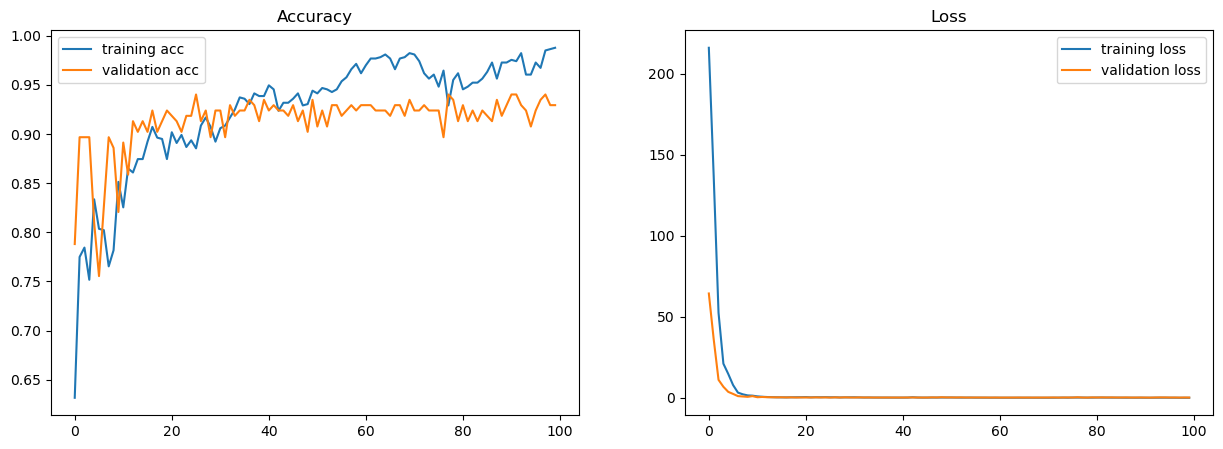

In [77]:
score_waveNet = model_wavenet.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score_waveNet[1]/1))
print("Loss: %.4f\n" % score_waveNet[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history_wavenet.history['accuracy'], label = 'training acc')
plt.plot(history_wavenet.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history_wavenet.history['loss'], label = 'training loss')
plt.plot(history_wavenet.history['val_loss'], label = 'validation loss')
plt.legend()

## SoundNet

In [78]:
# Ensure input shape is (batch_size, time_steps, channels)
if X_train.ndim == 3 and X_train.shape[-1] != 1:  # Shape: (batch_size, time_steps, channels)
    X_train = np.mean(X_train, axis=-1, keepdims=True)  # Convert to (batch_size, time_steps, 1)
    X_test = np.mean(X_test, axis=-1, keepdims=True)

input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, channels)

# Input layer
inputs = Input(shape=input_shape)

# SoundNet-style convolutional layers
x = Conv1D(filters=16, kernel_size=3, strides=1, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=256, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=512, kernel_size=3, strides=1, activation='relu', padding='same')(x)

# Flatten and classification layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(6, activation='softmax')(x)  # Assuming 6 classes

# Compile the model
model_soundnet = Model(inputs, outputs)
model_soundnet.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history_soundnet = model_soundnet.fit(X_train, y_train, validation_data=(X_test, y_test),  epochs=100, batch_size=200, verbose=1)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.4587 - loss: 15.1542 - val_accuracy: 0.2663 - val_loss: 7.5753
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5437 - loss: 7.3581 - val_accuracy: 0.8967 - val_loss: 3.1792
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8251 - loss: 5.2390 - val_accuracy: 0.8750 - val_loss: 1.5066
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8385 - loss: 2.6978 - val_accuracy: 0.8967 - val_loss: 0.7472
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8554 - loss: 1.0724 - val_accuracy: 0.8967 - val_loss: 0.5177
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8502 - loss: 0.7183 - val_accuracy: 0.8967 - val_loss: 0.4977
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8560 - loss: 0.6284 - val_accuracy: 0.8967 - val_loss: 0.4807
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8439 - loss: 0.6392 - val_accuracy: 0.8967 - val_los

### Efficiency of soundNet

Accuracy: 91%
Loss: 0.3649



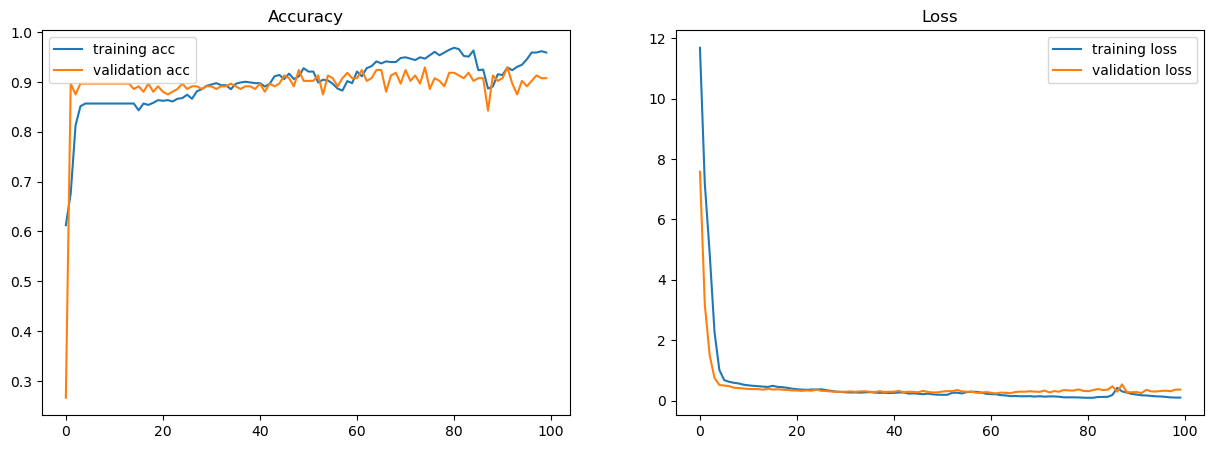

In [79]:
score_soundNet = model_soundnet.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score_soundNet[1]/1))
print("Loss: %.4f\n" % score_soundNet[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history_soundnet.history['accuracy'], label = 'training acc')
plt.plot(history_soundnet.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history_soundnet.history['loss'], label = 'training loss')
plt.plot(history_soundnet.history['val_loss'], label = 'validation loss')
plt.legend()

## VGGish

In [81]:

from tensorflow.keras.layers import BatchNormalization, Dropout


# Ensure input shape is (batch_size, time_steps, channels)
if X_train.ndim == 3 and X_train.shape[-1] != 1:  # Shape: (batch_size, time_steps, channels)
    X_train = np.mean(X_train, axis=-1, keepdims=True)  # Convert to (batch_size, time_steps, 1)
    X_test = np.mean(X_test, axis=-1, keepdims=True)

input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, channels)

# Input layer
inputs = Input(shape=input_shape)

# VGGish-style convolutional layers
x = Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=256, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = Conv1D(filters=256, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=512, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = Conv1D(filters=512, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# Flatten and fully connected layers
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(6, activation='softmax')(x)  # Assuming 6 classes

# Compile the model
model_vggish = Model(inputs, outputs)
model_vggish.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history_vggish = model_vggish.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, verbose=1)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 771ms/step - accuracy: 0.6880 - loss: 7.4194 - val_accuracy: 0.8967 - val_loss: 1.3907
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step - accuracy: 0.6868 - loss: 1.3539 - val_accuracy: 0.8641 - val_loss: 0.9587
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 619ms/step - accuracy: 0.8529 - loss: 0.6311 - val_accuracy: 0.8478 - val_loss: 0.8819
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step - accuracy: 0.8595 - loss: 0.5709 - val_accuracy: 0.7826 - val_loss: 0.9304
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step - accuracy: 0.8534 - loss: 0.6048 - val_accuracy: 0.8152 - val_loss: 1.0310
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 619ms/step - accuracy: 0.8527 - loss: 0.6292 - val_accuracy: 0.8315 - val_loss: 1.1302
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step - accuracy: 0.8467 - loss: 0.5772 - val_accuracy: 0.8043 - val_loss: 0.8880
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 615ms/step - accuracy: 0.8481 - loss: 0.5851 - val_accuracy: 0.7772 - v

## Efficiency of VGGish

Accuracy: 92%
Loss: 0.2214



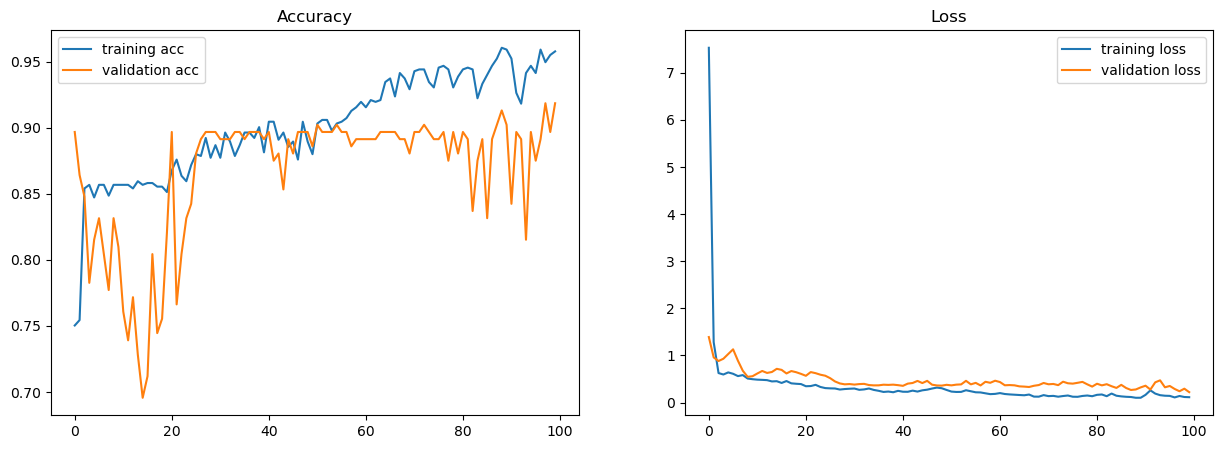

In [82]:
score_vggish = model_vggish.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score_vggish[1]/1))
print("Loss: %.4f\n" % score_vggish[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history_vggish.history['accuracy'], label = 'training acc')
plt.plot(history_vggish.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history_vggish.history['loss'], label = 'training loss')
plt.plot(history_vggish.history['val_loss'], label = 'validation loss')
plt.legend()

## DenseNet Manually

In [86]:
from tensorflow.keras.layers import GlobalAveragePooling1D
# Ensure input shape is (batch_size, time_steps, channels)
if X_train.ndim == 3 and X_train.shape[-1] != 1:  
    X_train = np.mean(X_train, axis=-1, keepdims=True)  
    X_test = np.mean(X_test, axis=-1, keepdims=True)

input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, channels)

# DenseNet-style Dense Block
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        conv = Conv1D(filters=growth_rate, kernel_size=3, padding="same", activation="relu")(x)
        conv = BatchNormalization()(conv)
        x = tf.keras.layers.Concatenate()([x, conv])  # Dense connection
    return x

# Transition Layer (reduces dimensions)
def transition_layer(x, reduction=0.5):
    filters = int(tf.keras.backend.int_shape(x)[-1] * reduction)
    x = Conv1D(filters, kernel_size=1, activation="relu")(x)
    x = BatchNormalization()(x)
    return x

# Input layer
inputs = Input(shape=input_shape)

# Initial Conv Layer
x = Conv1D(filters=64, kernel_size=7, strides=2, padding="same", activation="relu")(inputs)
x = BatchNormalization()(x)

# Dense Blocks + Transition Layers
x = dense_block(x, num_layers=4, growth_rate=32)
x = transition_layer(x)

x = dense_block(x, num_layers=6, growth_rate=32)
x = transition_layer(x)

x = dense_block(x, num_layers=8, growth_rate=32)

# Global Average Pooling & Output Layer
x = GlobalAveragePooling1D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(6, activation='softmax')(x)  # Assuming 6 classes

# Compile the model
model_densenet = Model(inputs, outputs)
model_densenet.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history_densenet = model_densenet.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, verbose=1)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 682ms/step - accuracy: 0.4411 - loss: 1.6024 - val_accuracy: 0.8967 - val_loss: 0.5312
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - accuracy: 0.8522 - loss: 0.8870 - val_accuracy: 0.8967 - val_loss: 0.8787
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 409ms/step - accuracy: 0.8554 - loss: 0.5773 - val_accuracy: 0.8967 - val_loss: 1.1612
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 427ms/step - accuracy: 0.8592 - loss: 0.4567 - val_accuracy: 0.8967 - val_loss: 1.3277
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - accuracy: 0.8681 - loss: 0.3594 - val_accuracy: 0.8967 - val_loss: 1.3278
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 399ms/step - accuracy: 0.8451 - loss: 0.4125 - val_accuracy: 0.8967 - val_loss: 1.2777
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - accuracy: 0.8573 - loss: 0.3798 - val_accuracy: 0.8967 - val_loss: 1.2475
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step - accuracy: 0.8698 - loss: 0.3267 - val_accuracy: 0.8967 - 

## Efficiency of DenseNet

Accuracy: 38%
Loss: 3.6139



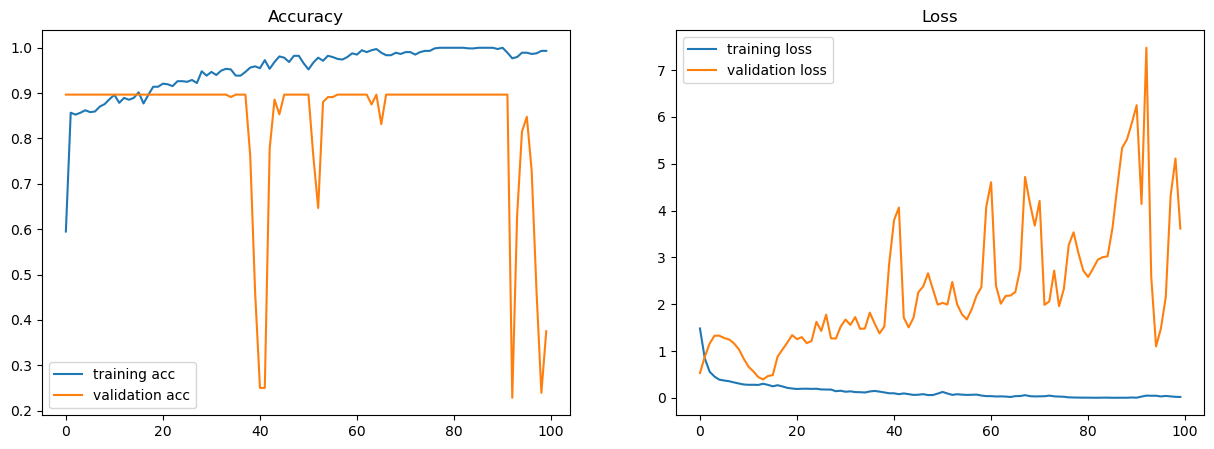

In [87]:
score_densenet = model_densenet.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score_densenet[1]/1))
print("Loss: %.4f\n" % score_densenet[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history_densenet.history['accuracy'], label = 'training acc')
plt.plot(history_densenet.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history_densenet.history['loss'], label = 'training loss')
plt.plot(history_densenet.history['val_loss'], label = 'validation loss')
plt.legend()

In [26]:

# matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumoina", "Bronchiolitis"]

# preds = model.predict(X_test)
# classpreds = np.argmax(preds, axis=1) # predicted classes 
# y_testclass = np.argmax(y_test, axis=1) # true classes

# cm = confusion_matrix(y_testclass, classpreds)
# print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# # Get percentage value for each element of the matrix
# cm_sum = np.sum(cm, axis=1, keepdims=True)
# cm_perc = cm / cm_sum.astype(float) * 100
# annot = np.empty_like(cm).astype(str)
# nrows, ncols = cm.shape
# for i in range(nrows):
#     for j in range(ncols):
#         c = cm[i, j]
#         p = cm_perc[i, j]
#         if i == j:
#             s = cm_sum[i]
#             annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
#         elif c == 0:
#             annot[i, j] = ''
#         else:
#             annot[i, j] = '%.1f%%\n%d' % (p, c)


# # Display confusion matrix 
# df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
# df_cm.index.name = 'Actual'
# df_cm.columns.name = 'Predicted'
# fig, ax = plt.subplots(figsize=(10,7))
# sn.heatmap(df_cm, annot=annot, fmt='')